In [1]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle


In [2]:
string = '/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff'

stack = io.imread(string)

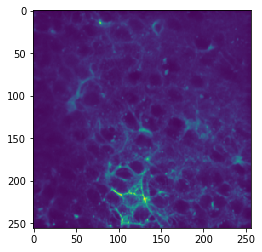

In [3]:
plt.imshow(np.mean(stack,axis=0))
mean_red = np.mean(stack[:,0:250,0:250],axis=0)
stack_red = stack[:,5:255,0:250]

In [4]:
root_folder = '/media/DATA/jbonato/astro_segm'

sys.path.insert(0,root_folder+'/RASTA/modules/')

In [5]:
from motion_correction import Motion_Correction

In [6]:
mc = Motion_Correction(1,True)

loading gpu_mod


In [7]:
mc = Motion_Correction(1,True)
%timeit mc.motion_corr(stack_red,ref_image=mean_red)

loading gpu_mod
433 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
mc = Motion_Correction(1,False)
%timeit mc.motion_corr(stack_red,ref_image=mean_red)

1.8 s ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
import cupy as cp
import cupyx.scipy.fft as cufft

# test
shape = mean_red.shape
mean_red_gpu = cp.asarray(mean_red) 
stack_red_gpu = cp.asarray(stack_red) 
it = time.time()
for i in range(500):
    
    out = cufft.fft2(mean_red_gpu)
    out2 = cufft.fft2(stack_red_gpu[i,:,:])
    image_product = out * out2.conj()
    image_product /= cp.maximum(cp.absolute(image_product), 100 * 2.220446049250313e-16)

    cross_correlation = cufft.ifft2(image_product)

    cross_correlation = cp.asnumpy(cross_correlation)

    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),cross_correlation.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])
    float_dtype = image_product.real.dtype
    shifts = np.stack(maxima).astype(float_dtype, copy=False)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]

    #print(shifts)
print(time.time()-it)

0.37653613090515137


In [8]:
it = time.time()
for i in range(500):
    src_freq = np.fft.fft2(mean_red)
    target_freq = np.fft.fft2(stack_red[i,:,:])
    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    eps = np.finfo(image_product.real.dtype).eps
    image_product /= np.maximum(np.abs(image_product), 100 * eps)

    cross_correlation = np.fft.ifft2(image_product)


    # Locate maximum
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),cross_correlation.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])
    float_dtype = image_product.real.dtype
    shifts = np.stack(maxima).astype(float_dtype, copy=False)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]

    #print(shifts)
print(time.time()-it)

1.6799466609954834


In [13]:
print(np.unravel_index(A.argmax(), A.shape))
print(np.unravel_index(B.argmax(), B.shape))

(0, 0)
(0, 0)


In [10]:
eps


2.220446049250313e-16

In [11]:
c = 2.220446049250313e-16
c

2.220446049250313e-16